# Defining and applying parallactic rotations

## The beam Jones matrix

As described in [Sokolowski et al. 2017](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/S1323358017000546), the beam Jones matrix can be written in the instrumental frame as:

$$
\mathbf{J}_{\mathrm{inst-frame}} =
\begin{bmatrix}
    j_{\mathrm{ew},\hat{\theta}}  & j_{\mathrm{ew},\hat{\phi}} \\
    j_{\mathrm{ns},\hat{\theta}} & j_{\mathrm{ns},\hat{\phi}} \\
\end{bmatrix},
$$

where $\mathrm{ns}$ refers to responses from the dipoles aligned with north-south, and $\mathrm{ew}$ refers to responses from the dipoles aligned with east-west. The $\hat{\theta}$ and $\hat{\phi}$ are the unit vectors in the direction towards zenith and azimuth, respectively. I've added a hat to the unit vectors to make it clear that they change for any given direction on the sky, $s$. See this incredible diagram that I have drawn for clarity:

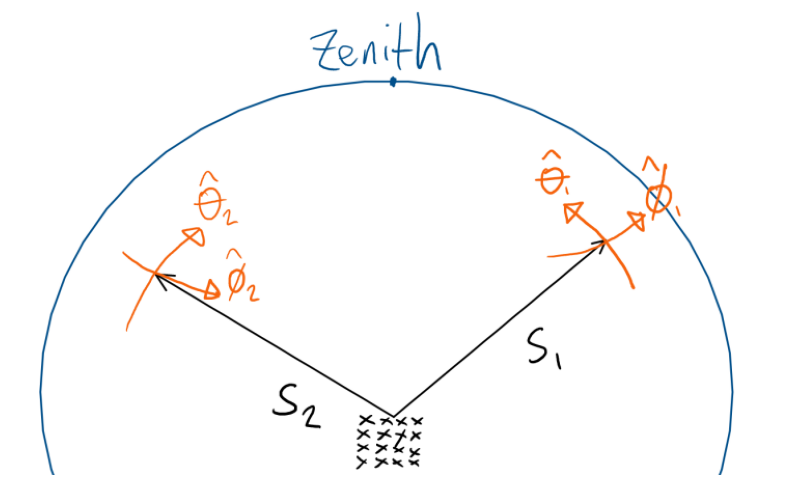

In [1]:
## Plot the image so it actually renders on ReadTHEDocs; embedding in markdown doesn't seem to work
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
img = mpimg.imread('beam_native_coords.png')
axs.imshow(img)
axs.axis('off')  # Optionally remove the axes for a cleaner display
plt.show()

So for every direction $s$ and for each dipole, we get the response to the electric field in the $\hat{\theta}$ and $\hat{\phi}$ directions. This is locked to the instrumental frame.

## Parallactic rotations

What we want in `WODEN` is a jones matrix aligned to celestial coorindates, a.k.a RA,Dec. This means our polarisation basis will be aligned with the celestial coordinates, and we can be consistent across different LSTs. This allows us to coherently add things, as well as apply the beam to Stokes IQUV parameters.

To do this, we need to rotate the $\hat{\theta}$ and $\hat{\phi}$ vectors so they point towards the celestial pole. I'll call the unit vectors in this new coordinate system $\hat{\alpha}, \hat{\delta}$, to mean aligned with RA and Dec. Turns out there is an angle that can achieve that, known as the parallactic angle $q$. This angle is the angle between the celestial pole and the zenith, as seen from the direction $s$. Visually, this is what it looks like:

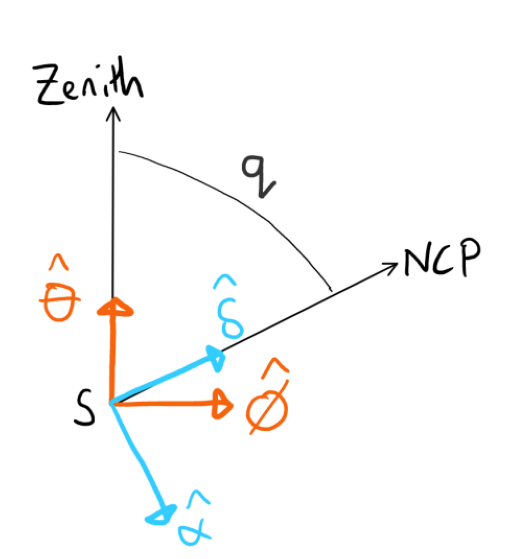

In [2]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
img = mpimg.imread('parallactic_rotate.png')
axs.imshow(img)
axs.axis('off')  # Optionally remove the axes for a cleaner display
plt.show()

So really it just boils down to this one simple rotation, for each direction. Writing that out in matrix form, we have a rotation such that:

$$
\begin{bmatrix}
    \hat{\alpha} \\
    \hat{\delta} \\
\end{bmatrix}
=
\begin{bmatrix}
    \cos(-q) & -\sin(-q) \\
    \sin(-q) & \cos(-q) \\
\end{bmatrix}
\begin{bmatrix}
    \hat{\phi} \\
    \hat{\theta} \\
\end{bmatrix}

 = \mathbf{R_q}
\begin{bmatrix}
    \hat{\phi} \\
    \hat{\theta} \\
\end{bmatrix}

$$

It's $-q$ because of the rotational sense of the parallactic angle I believe. Regardless of why, using negative $q$ works, so that's what we'll use. 

Often, people write out the jones matrix as

$$
\mathbf{J} =
\begin{bmatrix}
    g_x & D_x \\
    D_y & g_y \\
\end{bmatrix},
$$

where $g_x$ and $g_y$ are the gains, and $D_x$ and $D_y$ are the leakage terms, and $x,y$ refer to east-west, north-south. In our nomenclature, the gains are given by $j_{\mathrm{ns},\hat{\delta}}$ and $j_{\mathrm{ew},\hat{\alpha}}$. This means we can rewrite the Jones matrix as:

$$
\mathbf{J}_{\mathrm{celestial}} =
\begin{bmatrix}
    j_{\mathrm{ew},\hat{\alpha}} & j_{\mathrm{ew},\hat{\delta}} \\
    j_{\mathrm{ns},\hat{\alpha}} & j_{\mathrm{ns},\hat{\delta}}\\
\end{bmatrix},
$$

in the case where you want to label "x" as east-west, and "y" as north-south. However, in `WODEN`, we follow the IAU convention that "x" is north-south, and "y" is east-west. This means we write the Jones matrix as:

$$
\mathbf{J}_{\mathrm{WODEN}} =
\begin{bmatrix}
    j_{\mathrm{ns},\hat{\delta}} & j_{\mathrm{ns},\hat{\alpha}} \\
    j_{\mathrm{ew},\hat{\delta}} & j_{\mathrm{ew},\hat{\alpha}}\\
\end{bmatrix}.
$$

Explicitly writing out the rotations, we have:

$$
\begin{align}
    j_{\mathrm{ew},\hat{\alpha}} &= \cos(-q) j_{\mathrm{ew},\hat{\phi}} - \sin(-q) j_{\mathrm{ew},\hat{\theta}}  \\
    j_{\mathrm{ew},\hat{\delta}} &= \sin(-q) j_{\mathrm{ew},\hat{\phi}} + \cos(-q) j_{\mathrm{ew},\hat{\theta}}  \\
    j_{\mathrm{ns},\hat{\alpha}} &= \cos(-q) j_{\mathrm{ns},\hat{\phi}} - \sin(-q) j_{\mathrm{ns},\hat{\theta}}  \\
    j_{\mathrm{ns},\hat{\delta}} &= \sin(-q) j_{\mathrm{ns},\hat{\phi}} + \cos(-q) j_{\mathrm{ns},\hat{\theta}}  \\
\end{align}
$$


Of EXTREME importance to note here is the order of $\hat{\phi}$ and $\hat{\theta}$ in relation to the $\cos, \sin$ rotations. If you recall the instrumental Jones matrix $J_{\mathrm{inst-frame}}$ from above, a.k.a what comes out of the beam code before we rotate it, and the rotation matrix $\mathbf{R}_q$, you cannot do

$$
\begin{bmatrix}
    g_x & D_x \\
    D_y & g_y \\
\end{bmatrix}
\neq
\mathbf{R_q} \mathbf{J}_{\mathrm{inst-frame}}
$$

When you have a rotation matrix first, it applies a column-wise rotation to $\mathbf{J}_{\mathrm{inst-frame}}$. Each dipole response is stored along a *row*. You can therefore put the rotation matrix after the Jones matrix in the multiplication, which performs a row based multiplication, however:

$$
\begin{bmatrix}
    g_x & D_x \\
    D_y & g_y \\
\end{bmatrix}
\neq
\mathbf{J}_{\mathrm{inst-frame}} \mathbf{R_q}
$$

because the columns need be ordered $\phi,\theta$ in $\mathbf{J}_{\mathrm{inst-frame}}$, but they are ordered $\theta,\phi$. To be fair, this does the correct rotation, just the Jones that comes out has the gains on the off-diagonal, leakages on-diagonal. If you're REALLY gung ho about doing it via a rotation matrix in one go, you can do:

$$
\begin{bmatrix}
    g_x & D_x \\
    D_y & g_y \\
\end{bmatrix}
=
\mathbf{J}_{\mathrm{inst-frame}}
\begin{bmatrix}
    -\sin(-q) & \cos(-q) \\
    \cos(-q) & \sin(-q) \\
\end{bmatrix}
$$

where the reordering of $\mathbf{R}_q$ makes everything work out.


## Putting things into practice
Righto, now that we have the theory down, let's put it into practice. We'll use `hyperbeam` to generate a beam, and then do the rotations to check they are all kosher. Start up by defining so functions to get RA/Dec coords on the sky, and to plot all aspects of the beam.

We'll discover that with the MWA FEE model, there is one more negative that has to be applied.

In [3]:
import os
import erfa
import mwa_hyperbeam
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from eb_testing_code import plot_jones_on_sky

os.environ["MWA_BEAM_FILE"] = "/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"

def create_WCS(ra_cent, dec_cent, nside, radec_reso):
    header = fits.Header()

    header['NAXIS'] = 2

    header['NAXIS1'] = nside
    header['NAXIS2'] = nside

    header['CDELT1'] = -radec_reso
    header['CRPIX1'] = int(nside // 2) + 1
    header['CRVAL1'] = ra_cent
    header['CTYPE1'] = 'RA---SIN'
    header['CUNIT1']  = 'deg'

    header['CDELT2'] = radec_reso
    header['CRPIX2'] = int(nside // 2) + 1
    header['CRVAL2'] = dec_cent
    header['CTYPE2'] = 'DEC--SIN'
    header['CUNIT2']  = 'deg'

    header['EQUINOX'] = 2000.0
    
    return header, WCS(header).celestial

def plot_jones_on_sky(all_j00, all_j01, all_j10, all_j11, wcs, title=False,
                      show_plot = True, ra0=None, dec0=None):
    fig, axs = plt.subplots(4, 4, figsize=(16, 12), layout='constrained', subplot_kw={'projection': wcs})

    for row in range(4):
        if row == 3:
            j00 = np.angle(all_j00)
            j01 = np.angle(all_j01)
            j10 = np.angle(all_j10)
            j11 = np.angle(all_j11)
            tag = "Phase"
            
        elif row == 2:
            j00 = np.abs(all_j00)
            j01 = np.abs(all_j01)
            j10 = np.abs(all_j10)
            j11 = np.abs(all_j11)
            tag = "Abs"
        
        elif row == 0:
            j00 = np.real(all_j00)
            j01 = np.real(all_j01)
            j10 = np.real(all_j10)
            j11 = np.real(all_j11)
            tag = "Real"
        else:
            j00 = np.imag(all_j00)
            j01 = np.imag(all_j01)
            j10 = np.imag(all_j10)
            j11 = np.imag(all_j11)
            tag = "Imag"

        im0 = axs[0, row].imshow(j00, origin='lower')
        plt.colorbar(im0, ax=axs[0, row])
        axs[0, row].set_title(f'{tag} J00')
        
        im1 = axs[1, row].imshow(j01, origin='lower')
        plt.colorbar(im1, ax=axs[1, row])
        axs[1, row].set_title(f'{tag} J01')
        
        im2 = axs[2, row].imshow(j10, origin='lower')
        plt.colorbar(im2, ax=axs[2, row])
        axs[2, row].set_title(f'{tag} J10')
        
        im3 = axs[3, row].imshow(j11, origin='lower')
        plt.colorbar(im3, ax=axs[3, row])
        axs[3, row].set_title(f'{tag} J11')
        
    if title: fig.suptitle(title)

    for ax in axs.flatten(): ax.grid()

    if show_plot:
        plt.show()
    else:
        fig.savefig('beam_plot.png', bbox_inches='tight')

##Some nice and easy observational parameters
MWA_LAT_deg=-26.703319405555554
LST_deg = 0.0

First up, let's plot the `hyperbeam` `MWA_FEE` beam model without parallactic rotation. 

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


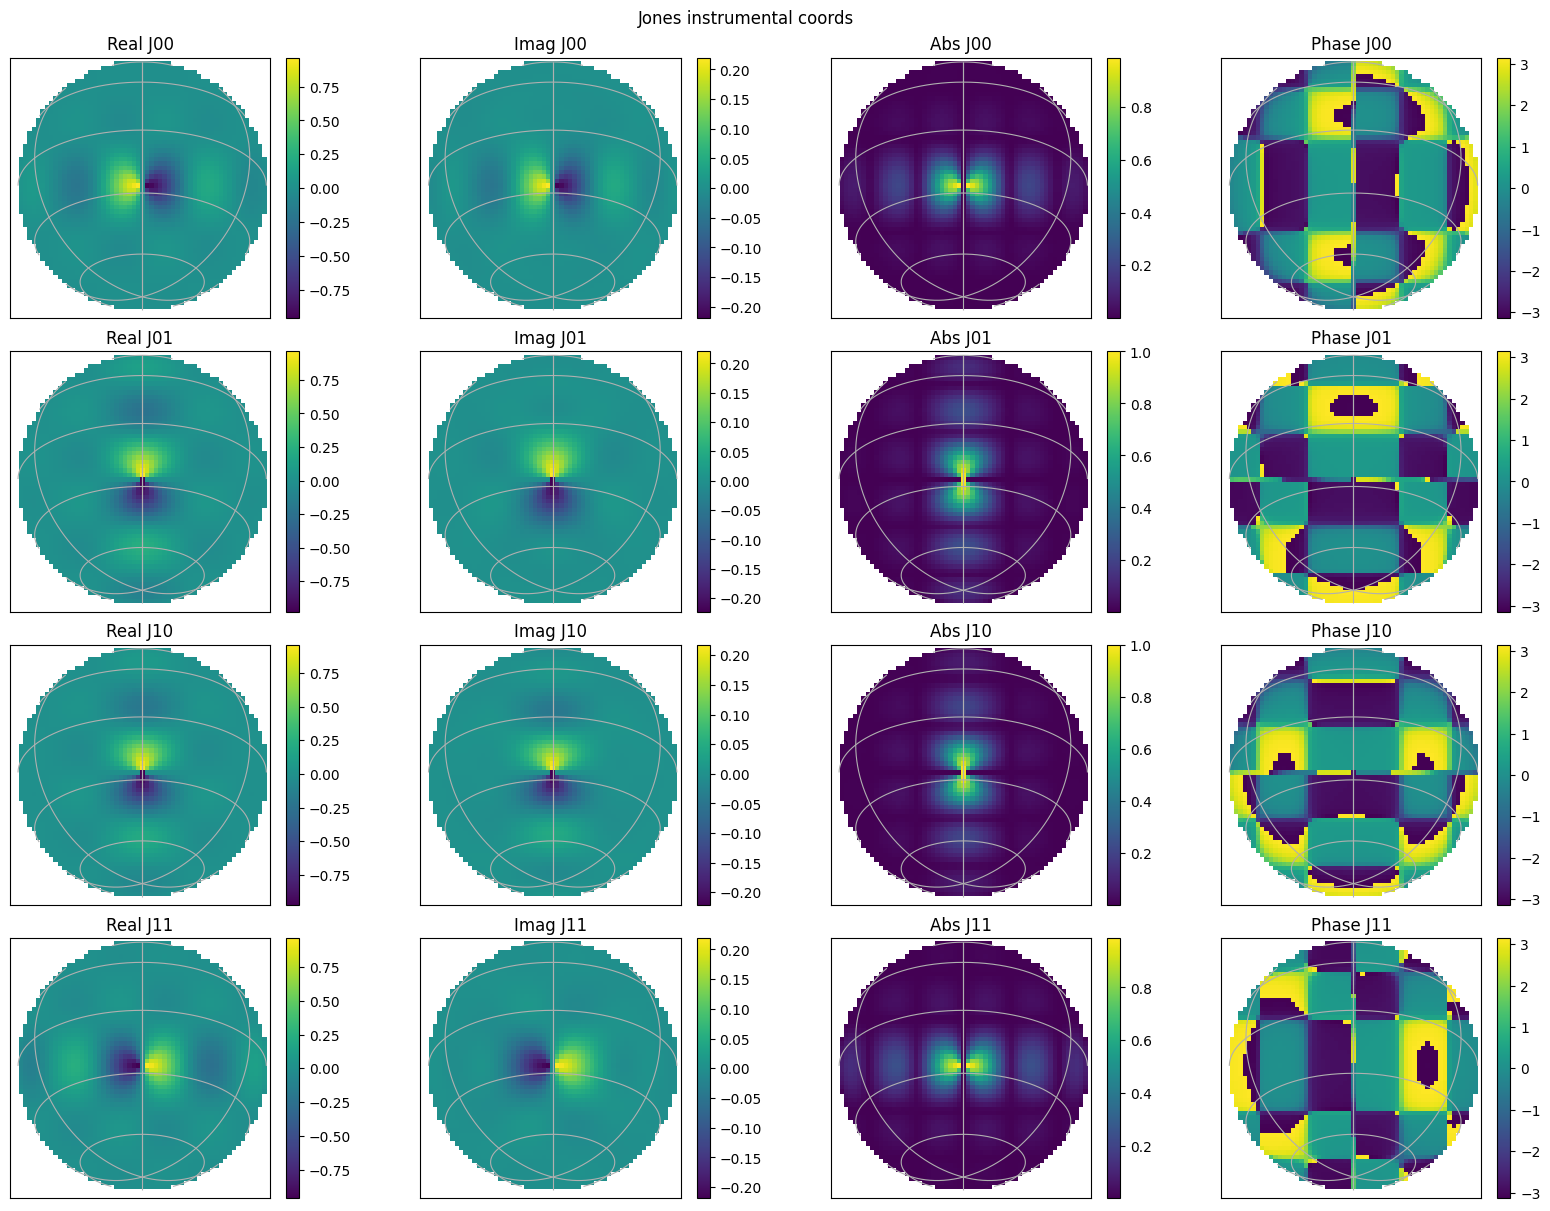

In [4]:
ra0, dec0 = LST_deg, MWA_LAT_deg

##Make a set of RA, DEC points via a WCS that covers the whole sky
nside=60
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

##Then use erfa to convert these values into azs, els
has = LST_deg - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
azs, els = erfa.hd2ae(np.radians(has), np.radians(decs), np.radians(MWA_LAT_deg))
##convert to zenith angle
zas = np.pi/2 - els

##Define a beam
beam = mwa_hyperbeam.FEEBeam()


##Setup some basic observational parameters. Just do a zenith beam.
freq = 180e+6
parallactic_rotation = False
beam_normalisation = True

amps = [1]*16
delays = [0]*16

##NB, if you supply a latitude to hyperbeam it will always apply a parallactic
## angle rotation, even if you set the parallactic_rotation flag to False
jones = beam.calc_jones_array(azs, zas, freq, delays, amps, beam_normalisation)

##Use the labelling of ew, ns, theta, phi we defined above
j_ew_theta = jones[:,0]
j_ew_phi = jones[:,1]
j_ns_theta = jones[:,2]
j_ns_phi = jones[:,3]

##reshape so we can plot em
j_ew_theta.shape = (nside, nside)
j_ew_phi.shape = (nside, nside)
j_ns_theta.shape = (nside, nside)
j_ns_phi.shape = (nside, nside)

plot_jones_on_sky(j_ew_theta, j_ew_phi, j_ns_theta, j_ns_phi, wcs, title="Jones instrumental coords")

Now let's rotate it to the celestial frame and see what we get. First, we'll calculate explicitly by expanding out the rotation, and plot where we say that $J_{00}$ is east-west, and $J_{11}$ is north-south.

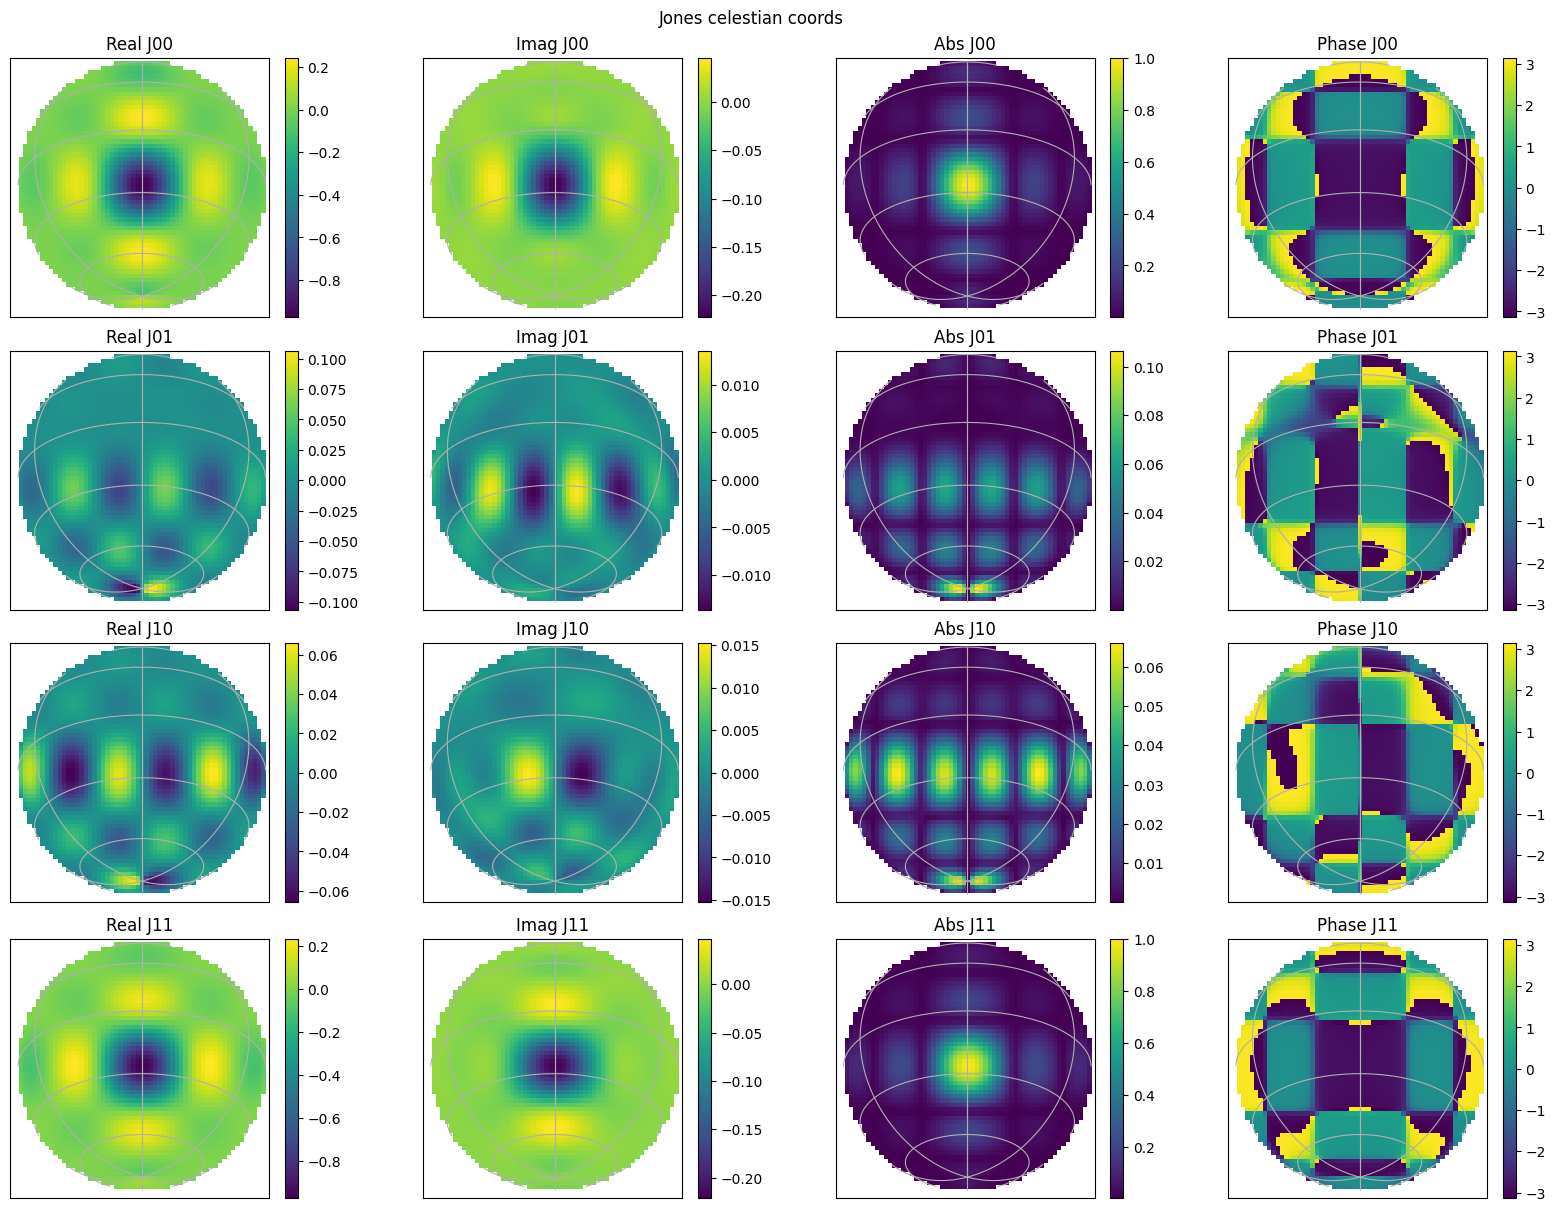

In [5]:
j_ew_theta = j_ew_theta.flatten()
j_ew_phi = j_ew_phi.flatten()
j_ns_theta = j_ns_theta.flatten()
j_ns_phi = j_ns_phi.flatten()
    
para_angles = erfa.hd2pa(np.radians(has), np.radians(decs), np.radians(MWA_LAT_deg))
    
j_ew_alpha = np.cos(-para_angles)*j_ew_phi - np.sin(-para_angles)*j_ew_theta
j_ew_delta = np.sin(-para_angles)*j_ew_phi + np.cos(-para_angles)*j_ew_theta
j_ns_alpha = np.cos(-para_angles)*j_ns_phi - np.sin(-para_angles)*j_ns_theta
j_ns_delta = np.sin(-para_angles)*j_ns_phi + np.cos(-para_angles)*j_ns_theta

j_ew_alpha.shape = (nside, nside)
j_ew_delta.shape = (nside, nside)
j_ns_alpha.shape = (nside, nside)
j_ns_delta.shape = (nside, nside)

plot_jones_on_sky(j_ew_alpha, j_ew_delta, j_ns_alpha, j_ns_delta, wcs, title="Jones celestian coords")


OK sweet, so the amplitude of our $J_{00}$ and $J_{11}$ look like typical MWA gains, which is what we want to see. The ancient wisdom of the `RTS` analytic MWA beam code however tells us that the real values of $J_{00}$ and $J_{11}$. The analytic model was purely real, so for consistency, just make the whole complex number negative. This is essentially just rotating in phase by $\pi$. I'm not smart enough to understand what than signifies.
NB, John Morgan noted this negative way back in 2019 https://github.com/MWATelescope/mwa_pb/issues/9 . So we're not alone in this thinking. Let's go ahead and take the negative of everything and replot.

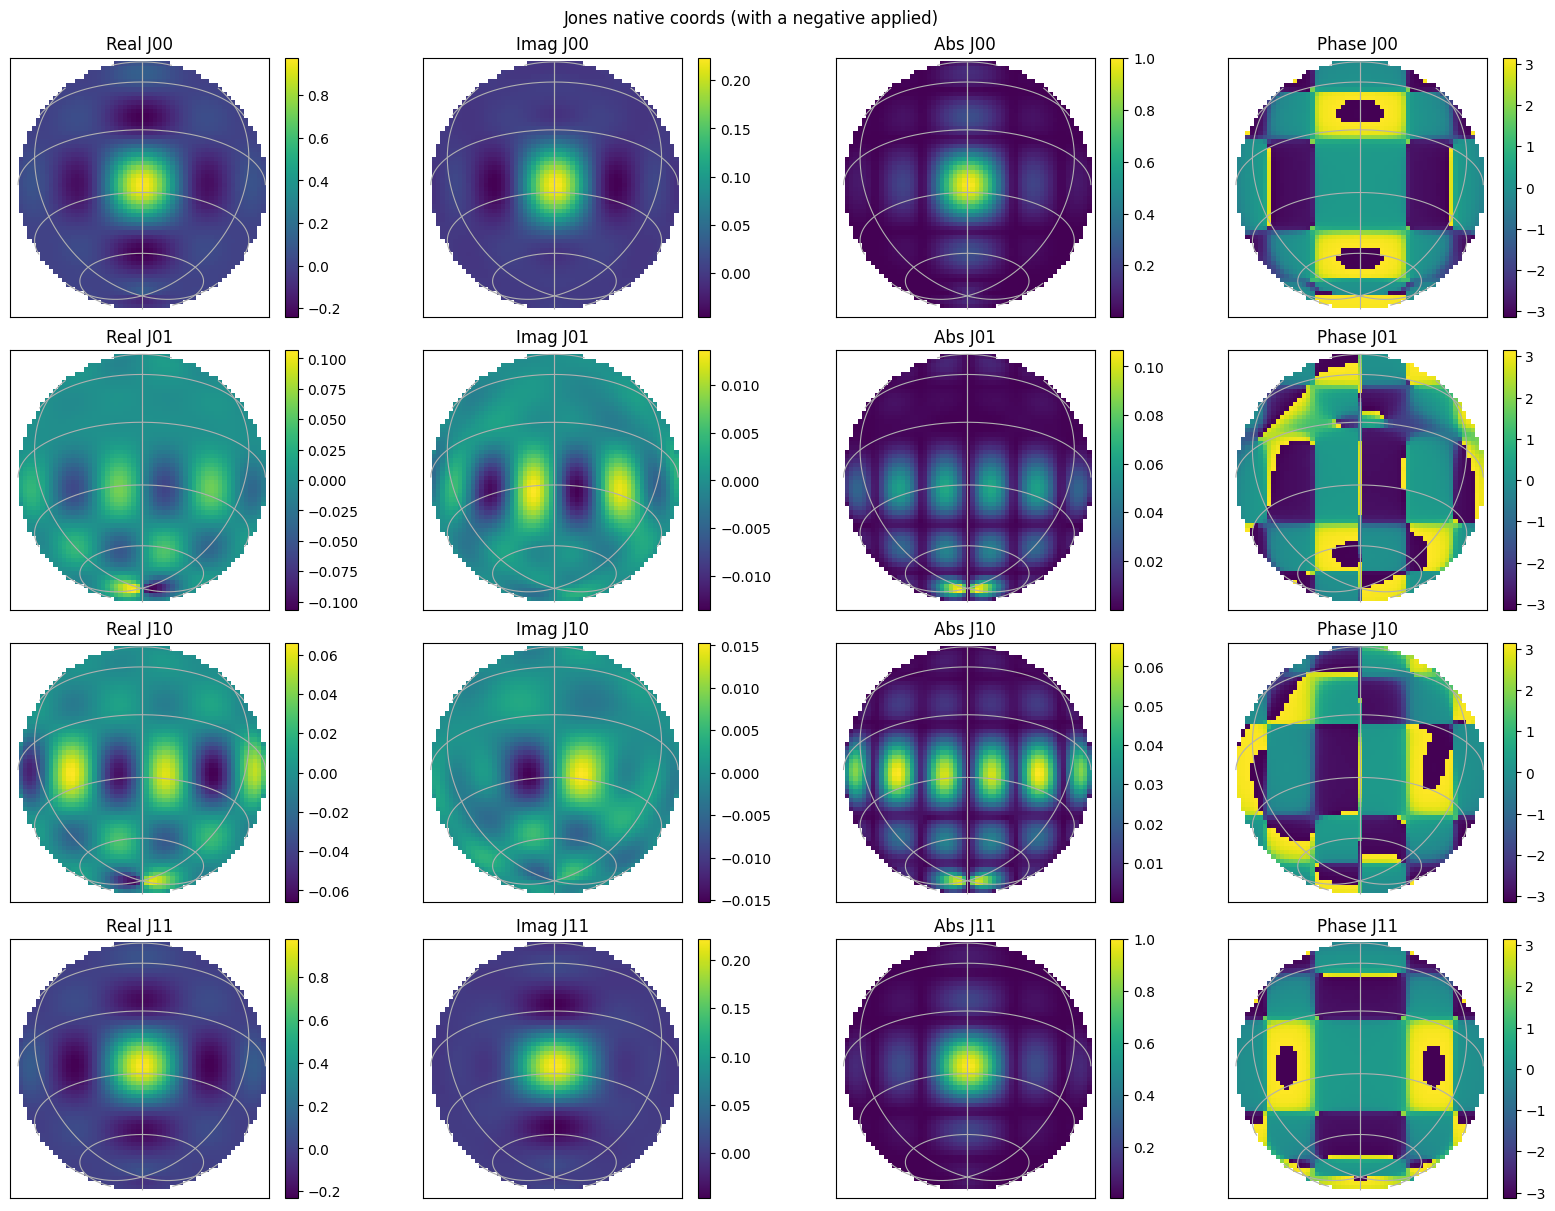

In [6]:
j_ew_alpha = -j_ew_alpha
j_ew_delta = -j_ew_delta
j_ns_alpha = -j_ns_alpha
j_ns_delta = -j_ns_delta

plot_jones_on_sky(j_ew_alpha, j_ew_delta, j_ns_alpha, j_ns_delta, wcs, title="Jones native coords (with a negative applied)")

Much better. Now, let's check that we have our east-west and north-south the correct way round. An east-west dipole is more sensitive to radiation coming from the north-south, and vice versa. That means if we subtract the magnitude of `j_ew_alpha` from `j_ns_delta`, we should see negative values in the north-south direction, and positive values in the east-west direction. Let's check that.

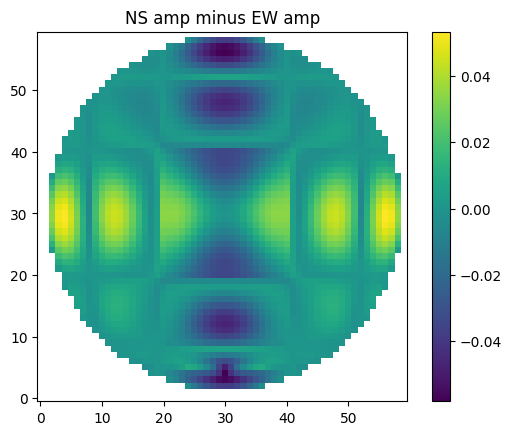

In [7]:
diff = np.abs(j_ns_delta) - np.abs(j_ew_alpha)
img = plt.imshow(diff, origin='lower')
plt.colorbar(img)
plt.title("NS amp minus EW amp")
plt.show()

Hooray, everything works as expected. As a check, let's do it via a matrix multiplication to check the results are the same.

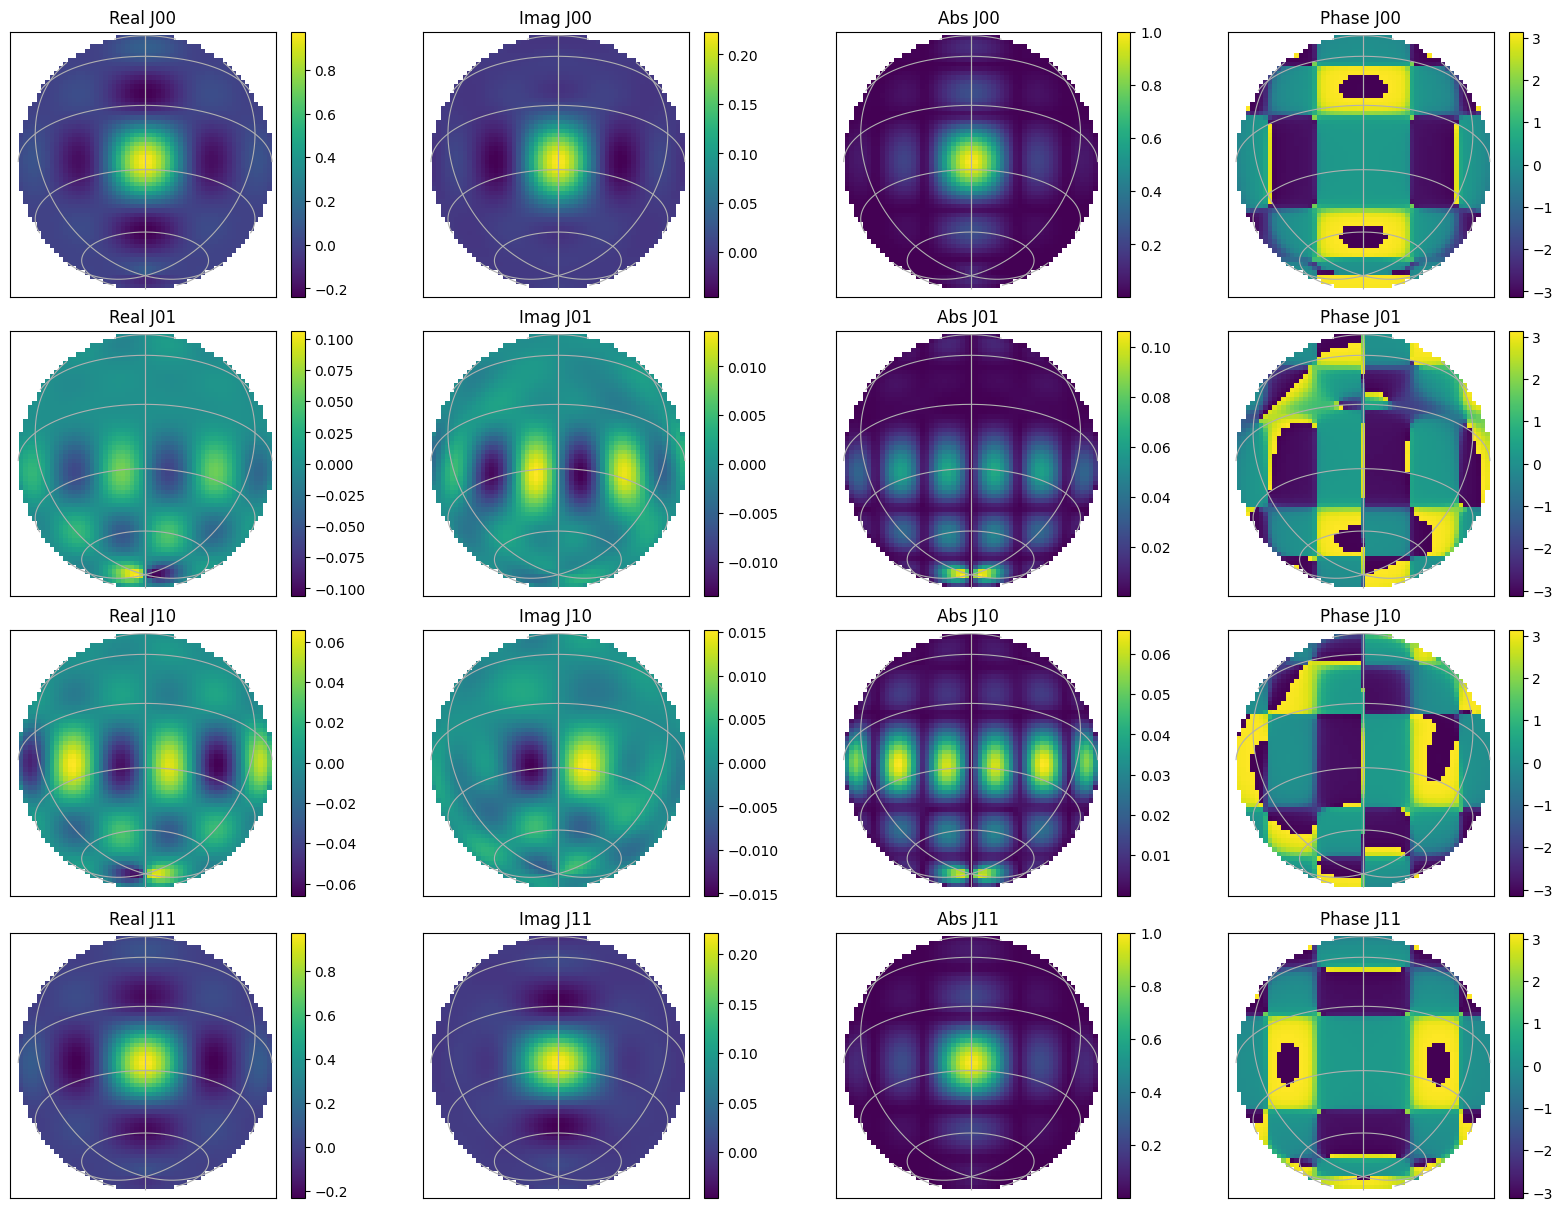

In [8]:
jones_inst = np.array([[j_ew_theta, j_ew_phi],
                       [j_ns_theta, j_ns_phi]])

rot_matrix = np.array([[-np.sin(-para_angles), np.cos(-para_angles)],
                       [np.cos(-para_angles), np.sin(-para_angles)]])

##Negative out front to be consistent with RTS beam
##We have two arrays of shape (2,2,nside*nside)
##We want to do a matrix multiplication of the 2x2 matrix with the 2x2 matrix
##The 'ijk,jlk->ilk' bit specifies what matrix multiplication to do, where
##the 'j' needs to match shape. Leaving the 'k' in all things means we don't
##multiply over that axis. ChatGPT for the win, thanks mate
rot_jones = -np.einsum('ijk,jlk->ilk', jones_inst, rot_matrix)

rot_jones.shape = (2, 2, nside, nside)

plot_jones_on_sky(rot_jones[0,0], rot_jones[0,1], rot_jones[1,0], rot_jones[1,1], wcs)

Let's double check everything is the same

True
True
True
True


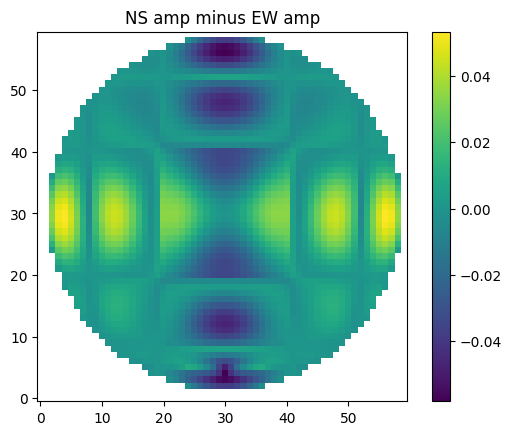

In [9]:
print(np.array_equal(rot_jones[0,0], j_ew_alpha, equal_nan=True))
print(np.array_equal(rot_jones[0,1], j_ew_delta, equal_nan=True))
print(np.array_equal(rot_jones[1,0], j_ns_alpha, equal_nan=True))
print(np.array_equal(rot_jones[1,1], j_ns_delta, equal_nan=True))

diff = np.abs(rot_jones[1,1]) - np.abs(rot_jones[0,0])
img = plt.imshow(diff, origin='lower')
plt.colorbar(img)
plt.title("NS amp minus EW amp")
plt.show()


Just to reaaaaaally really nail it down, this is what you get if you still do a row-wise multiplication, but with a 'standard' rotation matrix. 

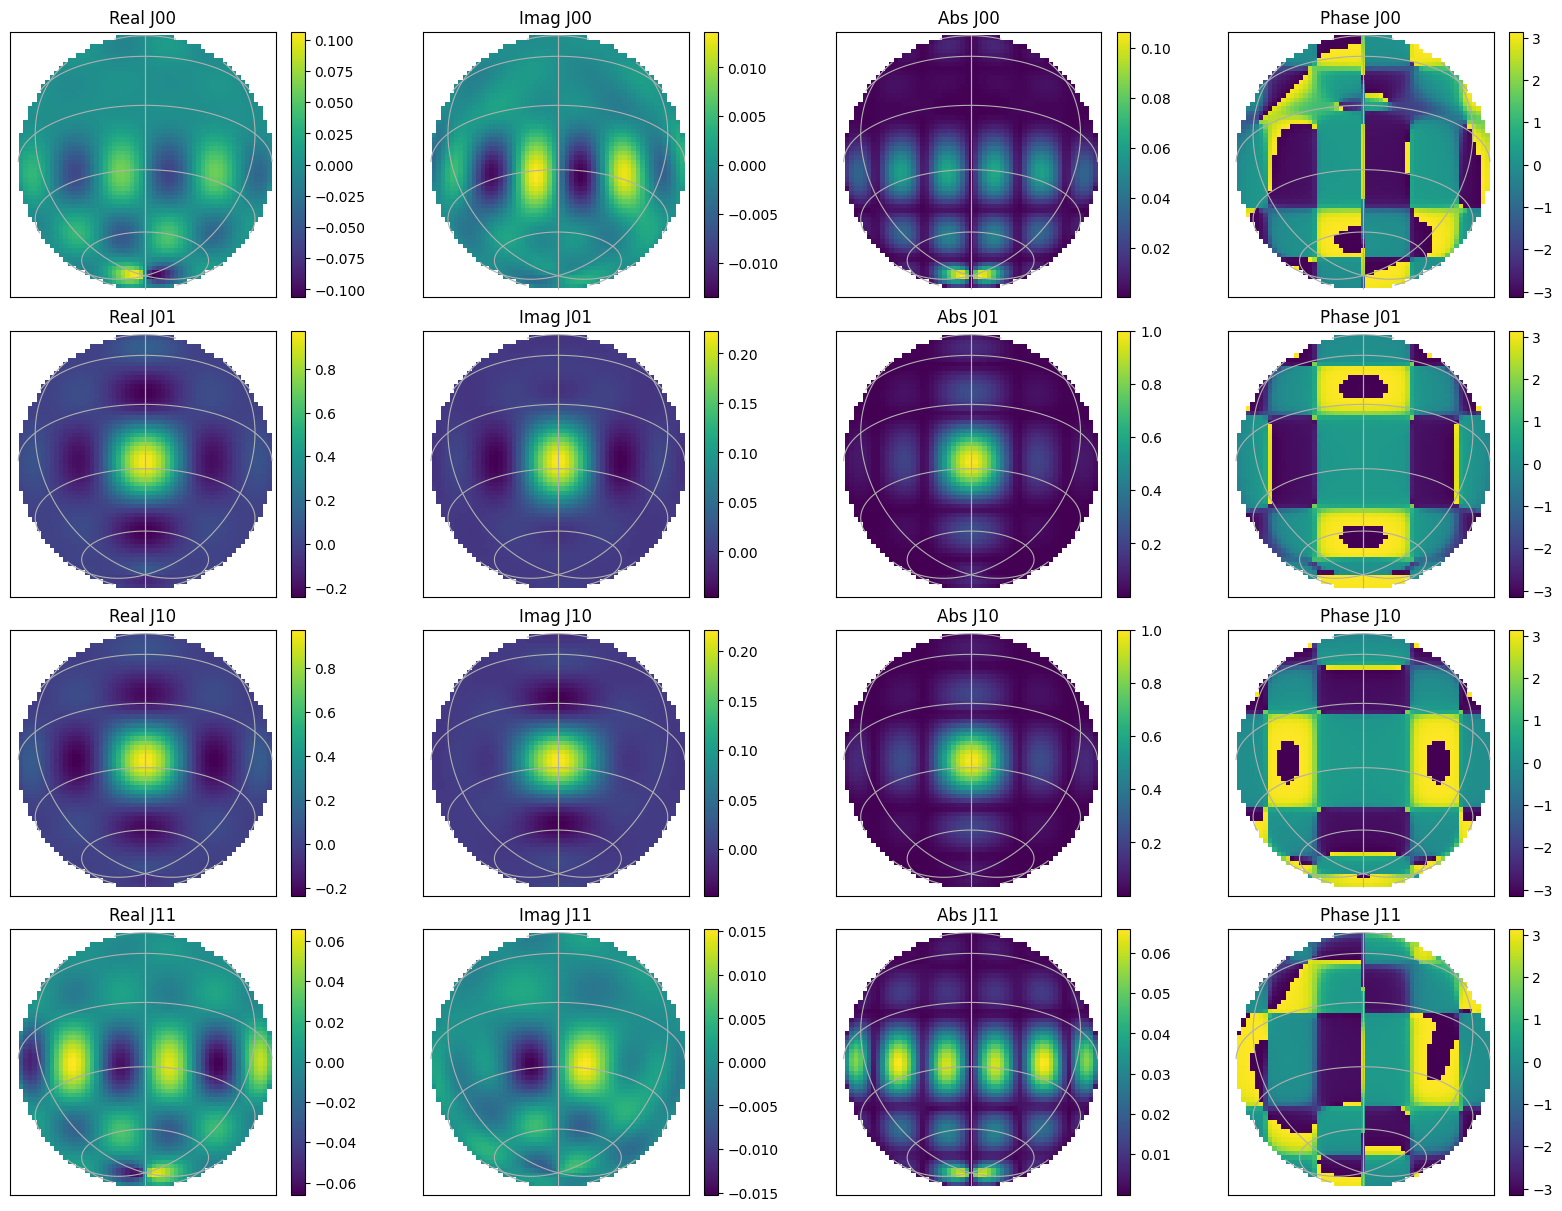

In [10]:
jones_inst = np.array([[j_ew_theta, j_ew_phi],
                       [j_ns_theta, j_ns_phi]])

rot_matrix_alt = np.array([[np.cos(-para_angles), -np.sin(-para_angles)],
                       [np.sin(-para_angles), np.cos(-para_angles), ]])

##Negative out front to be consistent with RTS beam
##We have two arrays of shape (2,2,nside*nside)
##We want to do a matrix multiplication of the 2x2 matrix with the 2x2 matrix
##The 'ijk,jlk->ilk' bit specifies what matrix multiplication to do, where
##the 'j' needs to match shape. Leaving the 'k' in all things means we don't
##multiply over that axis. ChatGPT for the win, thanks mate
rot_jones_alt = -np.einsum('ijk,jlk->ilk', jones_inst, rot_matrix_alt)

rot_jones_alt.shape = (2, 2, nside, nside)

plot_jones_on_sky(rot_jones_alt[0,0], rot_jones_alt[0,1], rot_jones_alt[1,0], rot_jones_alt[1,1], wcs)

Let's see if this is actually correct, just in the "wrong" order.

In [11]:
print(np.array_equal(rot_jones[0,0], rot_jones_alt[0,1], equal_nan=True))
print(np.array_equal(rot_jones[0,1], rot_jones_alt[0,0], equal_nan=True))
print(np.array_equal(rot_jones[1,0], rot_jones_alt[1,1], equal_nan=True))
print(np.array_equal(rot_jones[1,1], rot_jones_alt[1,0], equal_nan=True))

True
True
True
True
